# Training Convolutional Nural Network using large filters 

In [1]:
## For google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("/content/drive/My Drive/SENG474-FinalProject")

Mounted at /content/drive


## Loading in the Hyperparameters from the tunner

Installing the pakages for the tuner

In [2]:
!pip install keras-tuner --upgrade;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 4.7 MB/s 
     |████████████████████████████████| 1.6 MB 40.1 MB/s 


In order to load in the parameters from the tuner, first have to redefine the model.

In [3]:
from tensorflow.keras.layers import Rescaling
import keras_tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (100, 100, 1)

def call_existing_code(activation, dropout, dr, lr, momentum):
  inputs = keras.Input(input_shape)

  # scale down to proper size
  x = Rescaling(scale=1.0 / 255)(inputs)

  # this model is based off of large convolution filters

  x = layers.Conv2D(filters=1, kernel_size=3, activation=activation)(x)
  x = layers.Conv2D(filters=64, kernel_size=96, activation=activation)(x)
  x = layers.Flatten()(x)

  x = layers.Dense(units = 64*4)(x)
  if dropout: 
    x = layers.Dropout(rate = dr)(x)

  # input is ether stegano or not
  number_of_classes = 1
  
  output = layers.Dense(number_of_classes, activation="sigmoid")(x)

  model = keras.Model(inputs, output, name="Steganography_CNN")

  model.compile(
      optimizer=keras.optimizers.SGD(learning_rate = lr, momentum = momentum),
      loss="binary_crossentropy",
      metrics=['accuracy']
      )

  return model

def get_model(hp):
  activation = hp.Choice("activation", ['relu', 'tanh'])
  dropout = hp.Boolean("dropout")
  dr = hp.Float('dr', min_value=0.1, max_value=0.5,  sampling="log")
  lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  momentum = hp.Float("momentum", min_value=1e-4, max_value=0.9, sampling="log")
  
  model = call_existing_code(activation, dropout, dr, lr, momentum)

  return model

In [4]:
!ls 

images	SRM_Kernels1.npy   Steganography_CNN_Deep  X_256.pickle  y_256.pickle
logs	Steganography_CNN  X_100.pickle		   y_100.pickle


Reloading the hyper paramaters for the model

In [5]:

tuner = keras_tuner.RandomSearch(
    hypermodel=get_model,
    objective="val_accuracy",
    max_trials=40,
    executions_per_trial=2,
    directory=
    "/content/drive/MyDrive/SENG474-FinalProject",
    project_name = "Steganography_CNN"
)

tuner.reload()



In [6]:
best_hp = tuner.get_best_hyperparameters()

model = get_model(best_hp[0])

model.summary()

Model: "Steganography_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 100, 100, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 98, 98, 1)         10        
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 64)          589888    
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               147712    
                                                                 
 dropout (Dropout)           (None, 256)         

## Traning the Model

Loading in the data set

In [7]:
import pickle

with open("X_100.pickle", 'rb') as pickle_in:
    X = pickle.load(pickle_in)

with open("y_100.pickle", 'rb') as pickle_in:
    y = pickle.load(pickle_in)

In [8]:
import numpy as np

IMG_SIZE = 100

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

y = np.array(y).reshape(-1, 1)

Listing the first 10 images from the dataset

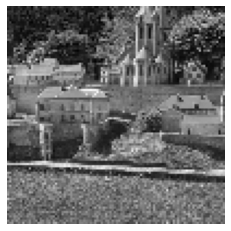

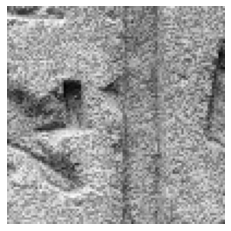

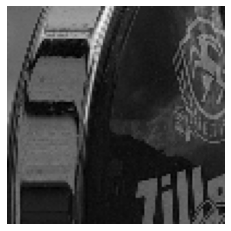

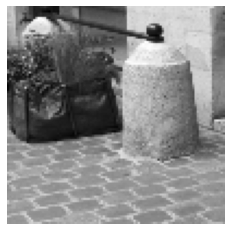

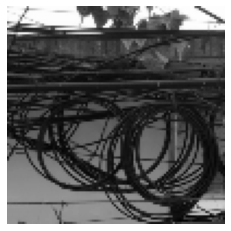

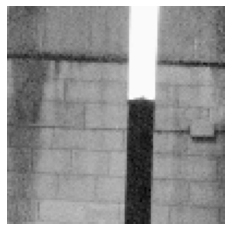

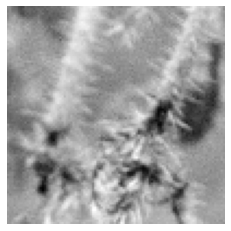

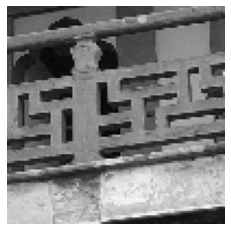

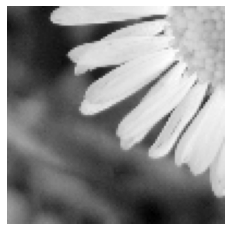

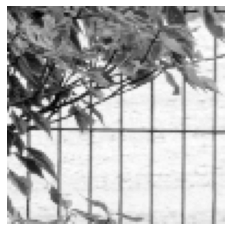

In [10]:
from matplotlib import pyplot as plt

for i in range(10):
  fig, ax = plt.subplots(1,1)
  ax.imshow(X[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
  ax.axis('off')

plt.show()

In [13]:
%%time

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1337)

CPU times: user 125 ms, sys: 174 ms, total: 300 ms
Wall time: 299 ms


In [14]:
X_train.shape

(90000, 100, 100, 1)

In [15]:
csv_logger = tf.keras.callbacks.CSVLogger('/content/drive/My Drive/SENG474-FinalProject/log.csv', separator=',', append=True)

early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)


callbacks = [csv_logger, early_stopping_callback, model_checkpoint_callback]

Traning the model on with 500 epochs

In [16]:
%%time

epochs = 500

model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks = callbacks)

Epoch 1/500
2813/2813 [==============================] - 26s 5ms/step - loss: 0.6933 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4989
Epoch 2/500
2813/2813 [==============================] - 12s 4ms/step - loss: 0.6933 - accuracy: 0.4962 - val_loss: 0.6933 - val_accuracy: 0.4916
Epoch 3/500
2813/2813 [==============================] - 12s 4ms/step - loss: 0.6933 - accuracy: 0.4980 - val_loss: 0.6936 - val_accuracy: 0.4899
Epoch 4/500
2813/2813 [==============================] - 12s 4ms/step - loss: 0.6933 - accuracy: 0.4980 - val_loss: 0.6935 - val_accuracy: 0.4871
Epoch 5/500
2813/2813 [==============================] - 12s 4ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6939 - val_accuracy: 0.4866
Epoch 6/500
2813/2813 [==============================] - 12s 4ms/step - loss: 0.6932 - accuracy: 0.4988 - val_loss: 0.6938 - val_accuracy: 0.4813
Epoch 7/500
2813/2813 [==============================] - 12s 4ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6938 -

In [17]:
pwd

'/content/drive/MyDrive/SENG474-FinalProject'

In [18]:
checkpoint_filepath = "./tmp/checkpoint"

model.load_weights(checkpoint_filepath)

Final test and train accuracy 

In [21]:

# Evaluate the model on the test data using `evaluate`
print("Evaluate on train data")
results = model.evaluate(X_train, y_train)
print("train loss, train acc:", results)

# Evaluate the model on the train data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on train data
2813/2813 [==============================] - 8s 3ms/step - loss: 0.6903 - accuracy: 0.5245
train loss, train acc: [0.6902790069580078, 0.5244777798652649]
Evaluate on test data
313/313 [==============================] - 1s 3ms/step - loss: 0.7353 - accuracy: 0.2799
test loss, test acc: [0.7353311777114868, 0.2799000144004822]
